# Iterative Least Squares for Sensor Fusion

In [1]:
#format the book
from __future__ import division, print_function
%matplotlib inline
import sys
sys.path.insert(0, '..');
sys.path.insert(0, '../kf_book')
import book_format
book_format.set_style()

A broad category of use for the Kalman filter is *sensor fusion*. For example, we might have a position sensor and a velocity sensor, and we want to combine the data from both to find an optimal estimate of state. In this section we will discuss a different case, where we have multiple sensors providing the same type of measurement. 

 The Global Positioning System (GPS) is designed so that at least 6 satellites are in view at any time at any point on the globe. The GPS receiver knows the location of the satellites in the sky relative to the Earth. At each epoch (instant in time) the receiver gets a signal from each satellite from which it can derive the *pseudorange* to the satellite. In more detail, the GPS receiver gets a signal identifying the satellite along with the time stamp of when the signal was transmitted. The GPS satellite has an atomic clock on board so this time stamp is extremely accurate. The signal travels at the speed of light, which is constant in a vacuum, so in theory the GPS should be able to produce an extremely accurate distance measurement to the measurement by measuring how long the signal took to reach the receiver. There are several problems with that. First, the signal is not traveling through a vacuum, but through the atmosphere. The atmosphere causes the signal to bend, so it is not traveling in a straight line. This causes the signal to take longer to reach the receiver than theory suggests. Second, the on board clock on the GPS *receiver* is not very accurate, so deriving an exact time duration is nontrivial. Third, in many environments the signal can bounce off of buildings, trees, and other objects, causing either a longer path or *multipaths*, in which case the receive receives both the original signal from space and the reflected signals. 

Let's look at this graphically. I will do this in 2D to make it easier to graph and see, but of course this will generalize to three dimensions. We know the position of each satellite and the range to each (the range is called the *pseudorange*; we will discuss why later). We cannot measure the range exactly, so there is noise associated with the measurement, which I have depicted with the thickness of the lines. Here is an example of four pseudorange readings from four satellites. I positioned them in a configuration which is unlikely for the actual GPS constellation merely to make the intersections easy to visualize. Also, the amount of error shown is not to scale with the distances, again to make it easier to see.

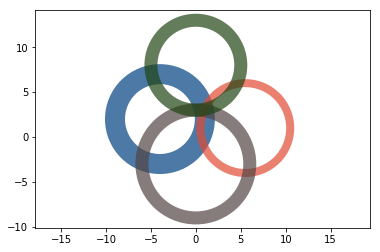

In [2]:
import ukf_internal
ukf_internal.show_four_gps()

In 2D two measurements are sometimes enough to determine a unique solution. There are two intersections of the range circles, but often the second intersection is not physically realizable (it is in space, or under ground). However, with GPS we also need to solve for time, so we would need a third measurement to get a 2D position.

However, since GPS is a 3D system we need to solve for the 3 dimensions of space, and 1 dimension of time. That is 4 unknowns, so in theory with 4 satellites we have all the information we need. However, we normally have at least 6 satellites in view, and often more than 6. This means the system is *overdetermined*. Finally, because of the noise in the measurements none of pseudoranges intersect exactly.

If you are well versed in linear algebra you know that this an extremely common problem in scientific computing, and that there are various techniques for solving overdetermined systems. Probably the most common approach used by GPS receivers to find the position is the *iterative least squares* algorithm, commonly abbreviated ILS. As you know, if the errors are Gaussian then the least squares algorithm finds the optimal solution. In other words, we want to minimize the square of the residuals for an overdetermined system.

Let's start with some definitions which should be familiar to you. First, we define the innovation as 

$$\delta \mathbf{\bar{z}}= \mathbf z - h(\mathbf{\bar{x}})$$

where $\mathbf z$ is the measurement, $h(\bullet)$ is the measurement function, and $\delta \mathbf{\bar{z}}$ is the innovation, which we abbreviate as $y$ in FilterPy. In other words, this is the equation $\mathbf{y} = \mathbf z - \mathbf{H\bar{x}}$ in the linear Kalman filter's update step.

Next, the *measurement residual* is

$$\delta \mathbf z^+ = \mathbf z - h(\mathbf x^+)$$

I don't use the plus superscript much because I find it quickly makes the equations unreadable, but $\mathbf x^+$ is the *a posteriori* state estimate, which is the predicted or unknown future state. In other words, the predict step of the linear Kalman filter computes this value. Here it is stands for the value of x which the ILS algorithm will compute on each iteration.

These equations give us the following linear algebra equation:

$$\delta \mathbf z^- = \mathbf H\delta \mathbf x + \delta \mathbf z^+$$

$\mathbf H$ is our measurement function, defined as

$$\mathbf H = \frac{d\mathbf H}{d\mathbf x} = \frac{d\mathbf z}{d\mathbf x}$$

We find the minimum of an equation by taking the derivative and setting it to zero. In this case we want to minimize the square of the residuals, so our equation is

$$ \frac{\partial}{\partial \mathbf x}({\delta \mathbf z^+}^\mathsf{T}\delta \mathbf z^+) = 0,$$

where

$$\delta \mathbf z^+=\delta \mathbf z^- - \mathbf H\delta \mathbf x.$$

Here I have switched to using the matrix $\mathbf H$ as the measurement function. We want to use linear algebra to peform the ILS, so for each step we will have to compute the matrix $\mathbf H$ which corresponds to $h(\mathbf{x^-})$ during each iteration.  $h(\bullet)$ is usually nonlinear for these types of problems so you will have to linearize it at each step (more about this soon).

For various reasons you may want to weigh some measurement more than others. For example, the geometry of the problem might favor orthogonal measurements, or some measurements may be more noisy than others. We can do that with the equation

$$ \frac{\partial}{\partial \mathbf x}({\delta \mathbf z^+}^\mathsf{T}\mathbf{W}\delta \mathbf z^+) = 0$$

If we solve the first equation for ${\delta \mathbf x}$ (the derivation is shown in the next section) we get

$${\delta \mathbf x} = {{(\mathbf H^\mathsf{T}\mathbf H)^{-1}}\mathbf H^\mathsf{T} \delta \mathbf z^-}
$$

And the second equation yields

$${\delta \mathbf x} = {{(\mathbf H^\mathsf{T}\mathbf{WH})^{-1}}\mathbf H^\mathsf{T}\mathbf{W} \delta \mathbf z^-}
$$

Since the equations are overdetermined we cannot solve these equations exactly so we use an iterative approach. An initial guess for the position is made, and this guess is used to compute  for $\delta \mathbf x$ via the equation above. $\delta \mathbf x$ is added to the intial guess, and this new state is fed back into the equation to produce another $\delta \mathbf x$. We iterate in this manner until the difference in the measurement residuals is suitably small.

### Derivation of ILS Equations

I will implement the ILS in code, but first let's derive the equation for $\delta \mathbf x$. You can skip the derivation if you want, but it is somewhat instructive and not too hard if you know basic linear algebra and partial differential equations.

Substituting $\delta \mathbf z^+=\delta \mathbf z^- - \mathbf H\delta \mathbf x$ into the partial differential equation we get

$$ \frac{\partial}{\partial \mathbf x}(\delta \mathbf z^- -\mathbf H \delta \mathbf x)^\mathsf{T}(\delta \mathbf z^- - \mathbf H \delta \mathbf x)=0$$

which expands to

$$ \frac{\partial}{\partial \mathbf x}({\delta \mathbf x}^\mathsf{T}\mathbf H^\mathsf{T}\mathbf H\delta \mathbf x - 
{\delta \mathbf x}^\mathsf{T}\mathbf H^\mathsf{T}\delta \mathbf z^- - 
{\delta \mathbf z^-}^\mathsf{T}\mathbf H\delta \mathbf x +
{\delta \mathbf z^-}^\mathsf{T}\delta \mathbf z^-)=0$$

We know that 

$$\frac{\partial \mathbf{A}^\mathsf{T}\mathbf B}{\partial \mathbf B} = \frac{\partial \mathbf B^\mathsf{T}\mathbf{A}}{\partial \mathbf B} = \mathbf{A}^\mathsf{T}$$

Therefore the third term can be computed as

$$\frac{\partial}{\partial \mathbf x}{\delta \mathbf z^-}^\mathsf{T}\mathbf H\delta \mathbf x = {\delta \mathbf z^-}^\mathsf{T}\mathbf H$$

and the second term as

$$\frac{\partial}{\partial \mathbf x}{\delta \mathbf x}^\mathsf{T}\mathbf H^\mathsf{T}\delta \mathbf z^-={\delta \mathbf z^-}^\mathsf{T}\mathbf H$$

We also know that
$$\frac{\partial \mathbf B^\mathsf{T}\mathbf{AB}}{\partial \mathbf B} = \mathbf B^\mathsf{T}(\mathbf{A} + \mathbf{A}^\mathsf{T})$$

Therefore the first term becomes

$$
\begin{aligned}
\frac{\partial}{\partial \mathbf x}{\delta \mathbf x}^\mathsf{T}\mathbf H^\mathsf{T}\mathbf H\delta \mathbf x &= {\delta \mathbf x}^\mathsf{T}(\mathbf H^\mathsf{T}\mathbf H + {\mathbf H^\mathsf{T}\mathbf H}^\mathsf{T})\\
&= {\delta \mathbf x}^\mathsf{T}(\mathbf H^\mathsf{T}\mathbf H + \mathbf H^\mathsf{T}\mathbf H) \\
&= 2{\delta \mathbf x}^\mathsf{T}\mathbf H^\mathsf{T}\mathbf H
\end{aligned}$$

Finally, the fourth term is

$$ \frac{\partial}{\partial \mathbf x}
{\delta \mathbf z^-}^\mathsf{T}\delta \mathbf z^-=0$$

Replacing the terms in the expanded partial differential equation gives us

$$
 2{\delta \mathbf x}^\mathsf{T}\mathbf H^\mathsf{T}\mathbf H -
 {\delta \mathbf z^-}^\mathsf{T}\mathbf H - {\delta \mathbf z^-}^\mathsf{T}\mathbf H
 =0
$$

$${\delta \mathbf x}^\mathsf{T}\mathbf H^\mathsf{T}\mathbf H -
 {\delta \mathbf z^-}^\mathsf{T}\mathbf H = 0$$
 
$${\delta \mathbf x}^\mathsf{T}\mathbf H^\mathsf{T}\mathbf H =
 {\delta \mathbf z^-}^\mathsf{T}\mathbf H$$

Multiplying each side by $(\mathbf H^\mathsf{T}\mathbf H)^{-1}$ yields

$${\delta \mathbf x}^\mathsf{T} =
{\delta \mathbf z^-}^\mathsf{T}\mathbf H(\mathbf H^\mathsf{T}\mathbf H)^{-1}$$

Taking the transpose of each side gives

$$\begin{aligned}
{\delta \mathbf x} &= ({{\delta \mathbf z^-}^\mathsf{T}\mathbf H(\mathbf H^\mathsf{T}\mathbf H)^{-1}})^\mathsf{T} \\
&={{(\mathbf H^\mathsf{T}\mathbf H)^{-1}}^T\mathbf H^\mathsf{T} \delta \mathbf z^-} \\
&={{(\mathbf H^\mathsf{T}\mathbf H)^{-1}}\mathbf H^\mathsf{T} \delta \mathbf z^-}
\end{aligned}$$

For various reasons you may want to weigh some measurement more than others. We can do that with the equation

$$ \frac{\partial}{\partial \mathbf x}({\delta \mathbf z}^\mathsf{T}\mathbf{W}\delta \mathbf z) = 0$$

Replicating the math above with the added $\mathbf{W}$ term results in

$${\delta \mathbf x} = {{(\mathbf H^\mathsf{T}\mathbf{WH})^{-1}}\mathbf H^\mathsf{T}\mathbf{W} \delta \mathbf z^-}
$$

### Implementing Iterative Least Squares

Our goal is to implement an iterative solution to 
$${\delta \mathbf x} = {{(\mathbf H^\mathsf{T}\mathbf H)^{-1}}\mathbf H^\mathsf{T} \delta \mathbf z^-}
$$

First, we have to compute $\mathbf H$, where $\mathbf H =  d\mathbf z/d\mathbf x$. To keep the example small so the results are easier to interpret we will do this in 2D. Therefore for $n$ satellites $\mathbf H$ expands to

$$\mathbf H = \begin{bmatrix}
\frac{\partial p_1}{\partial x_1} & \frac{\partial p_1}{\partial y_1} \\
\frac{\partial p_2}{\partial x_2} & \frac{\partial p_2}{\partial y_2} \\
\vdots & \vdots \\
\frac{\partial p_n}{\partial x_n} & \frac{\partial p_n}{\partial y_n}
\end{bmatrix}$$

We will linearize $\mathbf H$ by computing the partial for $x$ as

$$ \frac{estimated\_x\_position - satellite\_x\_position}{estimated\_range\_to\_satellite}$$

The equation for $y$ just substitutes $y$ for $x$.

Then the algorithm is as follows.

    def ILS:
        guess position
        while not converged:
            compute range to satellites for current estimated position
            compute H linearized at estimated position
            compute new estimate delta from (H^T H)'H^T dz
            new estimate = current estimate + estimate delta
            check for convergence
            

In [3]:
import numpy as np
from numpy.linalg import norm, inv
from numpy.random import randn
from numpy import dot

np.random.seed(1234)
user_pos = np.array([800, 200])

sat_pos = np.asarray(
    [[0, 1000],
     [0, -1000],
     [500, 500]], dtype=float)

def satellite_range(pos, sat_pos):
    """ Compute distance between position 'pos' and 
    the list of positions in sat_pos"""

    N = len(sat_pos)
    rng = np.zeros(N)

    diff = np.asarray(pos) - sat_pos

    for i in range(N):
        rng[i] = norm(diff[i])

    return norm(diff, axis=1)


def hx_ils(pos, sat_pos, range_est):
    """ compute measurement function where
    pos : array_like 
        2D current estimated position. e.g. (23, 45)
        
    sat_pos : array_like of 2D positions
        position of each satellite e.g. [(0,100), (100,0)]
        
    range_est : array_like of floats
        range to each satellite
    """
    
    N = len(sat_pos)
    H = np.zeros((N, 2))
    for j in range(N):
        H[j, 0] = (pos[0] - sat_pos[j, 0]) / range_est[j]
        H[j, 1] = (pos[1] - sat_pos[j, 1]) / range_est[j]
    return H


def lop_ils(zs, sat_pos, pos_est, hx, eps=1.e-6):
    """ iteratively estimates the solution to a set of
    measurement, given known transmitter locations"""
    pos = np.array(pos_est)

    with book_format.numpy_precision(precision=4):
        converged = False
        for i in range(20):
            r_est = satellite_range(pos, sat_pos)
            print('iteration:', i+1)

            H = hx(pos, sat_pos, r_est)        
            Hinv = inv(dot(H.T, H)).dot(H.T)

            # update position estimate
            y = zs - r_est
            print('innovation', y)

            Hy = np.dot(Hinv, y)
            pos = pos + Hy
            print('pos       {}\n\n'.format(pos))

            if max(abs(Hy)) < eps:
                converged = True
                break

    return pos, converged

# compute range to each sensor
rz = satellite_range(user_pos, sat_pos)

pos, converted = lop_ils(rz, sat_pos, (900, 90), hx=hx_ils)
print('Iterated solution: ', pos)

iteration: 1
innovation [-148.512    28.6789 -148.5361]
pos       [805.4175 205.2868]


iteration: 2
innovation [-0.1177 -7.4049 -0.1599]
pos       [800.04   199.9746]


iteration: 3
innovation [-0.0463 -0.001  -0.0463]
pos       [800. 200.]


iteration: 4
innovation [-0. -0. -0.]
pos       [800. 200.]


Iterated solution:  [800. 200.]


So let's think about this. The first iteration is essentially performing the computation that the linear Kalman filter computes during the update step:

$$\begin{aligned}
\mathbf y &= \mathbf z - \mathbf{Hx}\\
\mathbf x &= \mathbf x + \mathbf{Ky}
\end{aligned}$$

where the Kalman gain equals one. You can see that despite the very inaccurate initial guess (900, 90) the computed value for $\mathbf x$, (805.4, 205.3), was very close to the actual value of (800, 200). However, it was not perfect. But after three iterations the ILS algorithm was able to find the exact answer. So hopefully it is clear why we use ILS instead of doing the sensor fusion with the Kalman filter - it gives a better result. Of course, we started with a very inaccurate guess; what if the guess was better?

In [4]:
pos, converted = lop_ils(rz, sat_pos, (801, 201), hx=hx_ils)
print('Iterated solution: ', pos)

iteration: 1
innovation [-0.0009 -1.3868 -0.0024]
pos       [800.0014 199.9991]


iteration: 2
innovation [-0.0016 -0.     -0.0016]
pos       [800. 200.]


iteration: 3
innovation [-0. -0. -0.]
pos       [800. 200.]


Iterated solution:  [800. 200.]


The first iteration produced a better estimate, but it still could be improved upon by iterating.

I injected no noise in the measurement to test and display the theoretical performance of the filter. Now let's see how it performs when we inject noise.

In [5]:
# add some noise
nrz = []
for z in rz:
    nrz.append(z + randn())
pos, converted = lop_ils(nrz, sat_pos, (601,198.3), hx=hx_ils)
print('Iterated solution: ', pos)

iteration: 1
innovation [129.8823 100.461  107.5398]
pos       [831.4474 186.1222]


iteration: 2
innovation [-31.6446  -7.4837 -30.7861]
pos       [800.3284 198.8076]


iteration: 3
innovation [-0.6041 -0.3813  0.3569]
pos       [799.948  198.6026]


iteration: 4
innovation [-0.4803  0.0004  0.4802]
pos       [799.9476 198.6025]


iteration: 5
innovation [-0.4802  0.0007  0.4803]
pos       [799.9476 198.6025]


Iterated solution:  [799.948 198.602]


Here we can see that the noise means that we no longer find the exact solution but we are still able to quickly converge onto a more accurate solution than the first iteration provides.

This is far from a complete coverage of the iterated least squares algorithm, let alone methods used in GNSS to compute positions from GPS pseudoranges. You will find a number of approaches in the literature, including QR decomposition, SVD, and other techniques to solve the overdetermined system. For a nontrivial task you will have to survey the literature and perhaps design your algorithm depending on your specific sensor configuration, the amounts of noise, your accuracy requirements, and the amount of computation you can afford to do.